In [103]:
# (1)all features                                                  0.830077 0.885088 --> 0.76077
# (2)-ticketnum,ticketalpha                                        0.830526 0.878573 --> 0.75598
# (3)(2)-ticketnum,ticketalpha,shareTicket,shareCabin,ShareFare    0.831085 0.872703 --> 0.78469
# (4)(3) age_intuition                                             0.829855 0.881891 --> 0.79426

import re
import math
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from scipy import interp
from metrics import cross_validate
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import matplotlib.pylab as plt
from features1 import add_title,fill_age,fill_fare,fill_embarked,fill_cabin,fill_ticket,add_family, simplify_ages_intuition,simplify_ages_bins
 
seed = 1582

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])

PassengerId=total['PassengerId']

In [3]:
def add_surname(df):
    df['Surname']=df['Name'].apply(lambda x: x.split(",")[0])
    return df
total=add_surname(total)



In [4]:
total=add_title(total)
total=fill_age(total)
total.drop('Name',axis=1,inplace=True)
total=add_family(total)
total=fill_fare(total)
total=fill_embarked(total)
total=fill_cabin(total)
#total=fill_ticket(total)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Surname        1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 153.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
Passeng

/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
total=simplify_ages_intuition(total)

In [6]:
FFreq=total['Fare'].value_counts()
TFreq=total['Ticket'].value_counts()
CFreq=total['Cabin'].value_counts()
def add_ffreq(df):
    total['Ffreq']=total['Fare'].apply(lambda x: FFreq[x] if isinstance(x, float) else 0)
    return df
def add_tfreq(df):
    total['Tfreq']=total['Ticket'].apply(lambda x: TFreq[x])
    return df
def add_cfreq(df):
    total['Cfreq']=total['Cabin'].apply(lambda x: 9999 if isinstance(x, float) else CFreq[x])
    return df
total=add_ffreq(total)
total=add_cfreq(total)
total=add_tfreq(total)


In [7]:

def get_gid(r):
    if r['SibSp']+r['Parch']>0:
        return r['Surname']+" "+ str(r['SibSp']+r['Parch'])
    if r['Tfreq']>1:
        return str(r['Ticket'])
    if r['Cfreq']>1 and r['Cfreq']<12:
        return str(r['Cabin'])
    if r['Ffreq'] and r['Ffreq']<12:
        return str(r['Fare'])
    return "Single"

def add_gid(df):
    df['GID']=df.apply(get_gid,axis=1)
    return df     
total=add_gid(total)

In [8]:
def check_minor(r):
    if r['Age']< 14:
        if not r['Pclass']==3:
            return 1
    return 0
def add_minor(df):
    df['Minor']=df.apply(check_minor,axis=1)
    return df

total=add_minor(total)

In [9]:
def logl(a):
    a=max(a,0.00001)
    a=min(a,1.0-0.00001)
    return math.log(a/(1-a))


In [10]:
total1 = total.iloc[:891]
survived=total.loc[total1["Survived"]==1,["Pclass","Sex"]]
survived_1 = survived.loc[survived["Pclass"]==1,'Sex']
survived_2 = survived.loc[survived["Pclass"]==2,'Sex']
survived_3 = survived.loc[survived["Pclass"]==3,'Sex']

total_1 = total.loc[total1['Pclass']==1,['Sex','Survived']]
total_2 = total.loc[total1['Pclass']==2,['Sex','Survived']]
total_3 = total.loc[total1['Pclass']==3,['Sex','Survived']]

total_1_m = total_1.loc[total_1['Sex']=='male', 'Survived']
total_1_f = total_1.loc[total_1['Sex']=='female', 'Survived']
total_2_m = total_2.loc[total_2['Sex']=='male', 'Survived']
total_2_f = total_2.loc[total_2['Sex']=='female', 'Survived']
total_3_m = total_3.loc[total_3['Sex']=='male', 'Survived']
total_3_f = total_3.loc[total_3['Sex']=='female', 'Survived']

def get_logl(r):
    x=0
    if r["Pclass"]==1:
        x= survived_1.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_1_m.shape[0]
        else:
            x=1.0*x/total_1_f.shape[0]   
    elif r["Pclass"]==2:
        x= survived_2.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_2_m.shape[0]
        else:
            x=1.0*x/total_2_f.shape[0]
    else:
        x= survived_3.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_3_m.shape[0]
        else:
            x=1.0*x/total_3_f.shape[0]
    return logl(x)
    

def add_logl(df):
    df['SLogL']=0.0
    df.loc[:,('SLogL')]=df.apply(get_logl,axis=1)
    return df

total=add_logl(total)

In [11]:
def ticket_stat(ticket):
    if TFreq[ticket]>1:
        a=total.iloc[list(np.where(total['Ticket']==ticket)[0])]['Survived']
        if pd.isnull(a).sum() >0 and a.sum()>1:
            return 3
    return 0

def slogl_1(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['Ticket'].apply(ticket_stat)
    return df
total=slogl_1(total)

In [12]:
def slogl_2(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['GID'].apply(lambda x: -0.5 if x=='Single' else 0)
    return df
total=slogl_2(total)

In [13]:
def large_group(n):
    if n==7:
        return -3
    if n==8:
        return -1
    if n==11:
        return -3
    return 0

def slogl_3(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['Tfreq'].apply(large_group)
    return df
total=slogl_3(total)

In [14]:
total.loc[:,('SLogL')]=total.loc[:,('SLogL')]+total['Minor'].apply(lambda x: 8 if x==1 else 0)

In [69]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
Sex            1309 non-null int64
SmallFamily    1309 non-null int64
LargeFamily    1309 non-null int64
Minor          1309 non-null int64
SLogL          1309 non-null float64
dtypes: float64(1), int64(4)
memory usage: 61.4 KB


In [18]:
#total = pd.concat([total,pd.get_dummies(total['Title'],prefix='Title')],axis=1)
#total = pd.concat([total,pd.get_dummies(total['Embarked'],prefix='Embarked')],axis=1)
#total = pd.concat([total,pd.get_dummies(total['Cabin'], prefix='Cabin')], axis=1)
#total = pd.concat([total,pd.get_dummies(total['Pclass'], prefix="Pclass")],axis=1)
#total = pd.concat([total,pd.get_dummies(total['Age'], prefix="Age")],axis=1)
total['Sex'] = total['Sex'].map({'male':1,'female':0})
#total = pd.concat([total, pd.get_dummies(total['TicketAlpha'], prefix='TicketAlpha')], axis=1)
#total = pd.concat([total, pd.get_dummies(total['TicketNum'], prefix='TicketNum')], axis=1)

In [16]:
total.drop('Title',axis=1,inplace=True)
total.drop('Embarked',axis=1,inplace=True)
total.drop('Cabin', axis=1, inplace=True)
total.drop('Pclass',axis=1,inplace=True)
total.drop('Ticket', inplace=True, axis=1)
total.drop('PassengerId', inplace=True, axis=1)
total.drop('Survived', axis=1, inplace=True)
total.drop('Age',axis=1, inplace=True)

#
total.drop('Surname', axis=1, inplace=True)
total.drop('GID', axis=1, inplace=True)
total.drop('Fare', axis=1, inplace=True)
total.drop('Parch', axis=1, inplace=True)
total.drop('SibSp', axis=1, inplace=True)
total.drop('Singleton', axis=1, inplace=True)
total.drop('Ffreq', axis=1, inplace=True)
total.drop('Tfreq', axis=1, inplace=True)
total.drop('Cfreq', axis=1, inplace=True)
total.drop('FamilySize', axis=1, inplace=True)

In [19]:
data_y=train['Survived']
data_x=total.iloc[range(len(data_y))]
test_x=total.iloc[len(data_y):]


In [134]:
fixed_params = {
    'max_depth':6,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':130,
    'gamma':0.1,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'objective':'binary:logistic',
}
model = xgb.XGBClassifier(**fixed_params)
bagged = BaggingClassifier(model, n_estimators=5)
#calibrated = CalibratedClassifierCV(model, method='isotonic', cv=5)
#calibrated1 = CalibratedClassifierCV(model, method='sigmoid', cv=5)

In [137]:
cross_validate(calibrated1, data_x, data_y,seed=seed, rep=10, cv=5)

(0.81490929634046827,
 0.86730183960941631,
 0.42583349280427718,
 0.6911764705882353,
 0.8103448275862069)

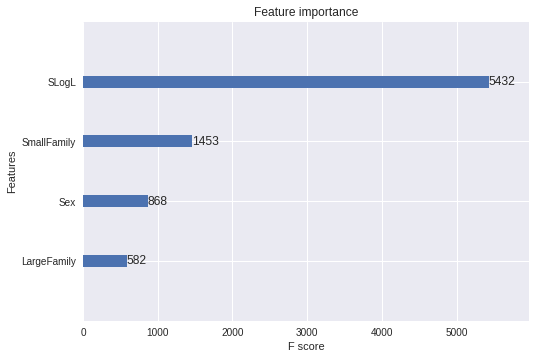

In [73]:
xgb.plot_importance(model)
plt.show()

(0.81179586968802964,
 0.87097292875521404,
 0.42377170626310834,
 0.6865671641791045,
 0.8070175438596491)

In [133]:
fixed_params = {
    'max_depth':6,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':1000,
    'gamma':0.1,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'objective':'binary:logistic',
}

alg=xgb.XGBClassifier(**fixed_params)
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(data_x, label=data_y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                  nfold=5,
                  metrics='auc',
                  early_stopping_rounds=50,
                  )
print cvresult.shape[0]

130


In [126]:
# disable gamma, reg_alpha
# train depth+child_weight
# gamma
# subsample+ subcol
# reg_alpha
cv_params = {
#    'max_depth':range(3,10),
#    'min_child_weight':range(6),
#    'gamma':[i/10.0 for i in range(0,10)],
#    'subsample':[0.5,0.6,0.7,0.8,0.9],
#    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],
#    'subsample':[0.8,0.85,0.9,0.95],
#    'colsample_bytree':[0.85,0.9,0.95],    
    'reg_alpha':[1e-9, 1e-7,1e-5,1e-3]
#    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05], 
#    'reg_alpha':[0.5,1,5,10],
#    'learning_rate':[0.05,0.1,0.2],
#    'n_estimators':[20,40,60,100,200]
}
fixed_params = {
    'max_depth':6,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':88,
    'gamma':0.1,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'objective':'binary:logistic',
}
optimized_gbm = GridSearchCV(xgb.XGBClassifier(**fixed_params),
                            cv_params,
                            scoring='roc_auc',
                            cv=10,
                            n_jobs=-1)
optimized_gbm.fit(data_x,data_y)


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_chil_weight=1,
       min_child_weight=1, missing=None, n_estimators=88, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=1582,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [1e-09, 1e-07, 1e-05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [127]:
optimized_gbm.grid_scores_,optimized_gbm.best_params_,optimized_gbm.best_score_

([mean: 0.87441, std: 0.03921, params: {'reg_alpha': 1e-09},
  mean: 0.87441, std: 0.03921, params: {'reg_alpha': 1e-07},
  mean: 0.87441, std: 0.03921, params: {'reg_alpha': 1e-05},
  mean: 0.87441, std: 0.03921, params: {'reg_alpha': 0.001}],
 {'reg_alpha': 1e-09},
 0.8744088484400095)

In [138]:
fixed_params = {
    'max_depth':6,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':130,
    'gamma':0.1,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'objective':'binary:logistic',
}
model = xgb.XGBClassifier(**fixed_params)
model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
model.fit(data_x,data_y)
test_predictions = model.predict(test_x)
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': test_predictions })
submission.to_csv("submission.csv", index=False)